In [18]:
# Imports
import numpy as np
import pandas as pd 
from scipy.stats import linregress
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import brier_score_loss

# Summary

This notebook contains functions for computing Elo ratings during regular seasons and tournaments, summarizing team performance in both men's and women's events. It produces two ready to use CSV files containing the following key team information:

- **Rating_Mean:** The average team rating in a regular season.
- **Rating_Median:** The median team rating in a regular season.
- **Rating_Last:** The last rating in a regular season/ the final rating before the tournament.
- **Rating_Std:** Standard Deviation of team ratings.
- **Rating_Max:** The maximum team rating in a season.
- **Rating_Min:** The minimum team rating in a season.
- **Rating_Trend:** The slope of the team's rating over the season.

# Functions

In [ ]:
def calculate_elo(teams, data, initial_rating=2000, k=140, alpha=None, weights=False, nan_score=1):
    '''
    Calculate Elo ratings for each team based on match data.

    Parameters:
    - teams (array-like): Containing Team-IDs.
    - data (pd.DataFrame): DataFrame with all matches in chronological order.
    - initial_rating (float): Initial rating of an unranked team (default: 2000).
    - k (float): K-factor, determining the impact of each match on team ratings (default: 140).
    - alpha (float or None): Tuning parameter for the multiplier for the margin of victory. No multiplier if None.

    Returns: 
    - list: Historical ratings of the winning team (WTeam).
    - list: Historical ratings of the losing team (LTeam).
    '''
    
    # Dictionary to keep track of current ratings for each team
    team_dict = {}
    for team in teams:
        team_dict[team] = initial_rating
        
    # Lists to store ratings for each team in each game
    r1, r2 = [], []
    loss = []
    margin_of_victory = 1
    weight = 1

    # Iterate through the game data
    for wteam, lteam, ws, ls, w  in tqdm(zip(data.WTeamID, data.LTeamID, data.WScore, data.LScore, data.weight), total=len(data)):

        # Calculate expected outcomes based on Elo ratings
        rateW = 1 / (1 + 10 ** ((team_dict[lteam] - team_dict[wteam]) / initial_rating))
        rateL = 1 / (1 + 10 ** ((team_dict[wteam] - team_dict[lteam]) / initial_rating))
        
        if alpha:
                margin_of_victory = (ws - ls)/alpha
        if isinstance(weights, (list, np.ndarray, pd.Series)):
            weight = w

        # Update ratings for winning and losing teams
        team_dict[wteam] += w * k * margin_of_victory * (1 - rateW)
        team_dict[lteam] += w * k * margin_of_victory * (0 - rateL)

        # Ensure that ratings do not go below 1
        if team_dict[lteam] < 1:
            team_dict[lteam] = 1
            
        # Append current ratings for teams to lists
        r1.append(team_dict[wteam])
        r2.append(team_dict[lteam])
        loss.append((1-rateW)**2)
        
    return r1, r2, loss

def create_elo_data(teams, data, initial_rating=2000, k=140, alpha=None, weights=None, nan_score=1):
    '''
    Create a DataFrame with summary statistics of Elo ratings for teams based on historical match data.

    Parameters:
    - teams (array-like): Containing Team-IDs.
    - data (pd.DataFrame): DataFrame with all matches in chronological order.
    - initial_rating (float): Initial rating of an unranked team (default: 2000).
    - k (float): K-factor, determining the impact of each match on team ratings (default: 140).
    - weights (array-like): Containing weights for each match.

    Returns: 
    - DataFrame: Summary statistics of Elo ratings for teams throughout a season.
    '''
    
    if isinstance(weights, (list, np.ndarray, pd.Series)):
        data['weight'] = weights
    else:
        data['weight'] = 1
    
    r1, r2, loss = calculate_elo(teams, data, initial_rating, k, alpha, weights, nan_score)
    # Calculate loss only on tourney results
    loss = np.mean(np.array(loss)[data.tourney == 1])
    print(f"Loss: {loss}")
    
    # Concatenate arrays vertically
    seasons = np.concatenate([data.Season, data.Season])
    days = np.concatenate([data.DayNum, data.DayNum])
    teams = np.concatenate([data.WTeamID, data.LTeamID])
    tourney = np.concatenate([data.tourney, data.tourney])
    ratings = np.concatenate([r1, r2])
    # Create a DataFrame
    rating_df = pd.DataFrame({
        'Season': seasons,
        'DayNum': days,
        'TeamID': teams,
        'Rating': ratings,
        'Tourney': tourney
    })

    # Sort DataFrame and remove tournament data
    rating_df.sort_values(['TeamID', 'Season', 'DayNum'], inplace=True)
    rating_df = rating_df[rating_df['Tourney'] == 0]
    grouped = rating_df.groupby(['TeamID', 'Season'])
    results = grouped['Rating'].agg(['mean', 'median', 'std', 'min', 'max', 'last'])
    results.columns = ['Rating_Mean', 'Rating_Median', 'Rating_Std', 'Rating_Min', 'Rating_Max', 'Rating_Last']
    results['Rating_Trend'] = grouped.apply(lambda x: linregress(range(len(x)), x['Rating']).slope, include_groups=False)
    results.reset_index(inplace=True)
    
    return results

# Apply Functions and Save Results to CSV

In [25]:
# Load and Process Data Men's Tourney
regular_m = pd.read_csv('/home/lya/Workspace/mmm25/kaggle/input/march-machine-learning-mania-2025/MRegularSeasonCompactResults.csv')
tourney_m = pd.read_csv('/home/lya/Workspace/mmm25/kaggle/input/march-machine-learning-mania-2025/MNCAATourneyCompactResults.csv')
teams_m = pd.read_csv('/home/lya/Workspace/mmm25/kaggle/input/march-machine-learning-mania-2025/MTeams.csv')

regular_m['tourney'] = 0
tourney_m['tourney'] = 1
regular_m['weight'] = 1
tourney_m['weight'] = 0.7

data_m = pd.concat([regular_m, tourney_m])
data_m.sort_values(['Season', 'DayNum'], inplace=True)
data_m.reset_index(inplace=True, drop=True)

elo_df_men = create_elo_data(teams_m.TeamID, data_m, initial_rating=1200, k=125, alpha=None, weights=data_m['weight'])
elo_df_men.head(10)

100%|██████████| 194314/194314 [00:00<00:00, 609219.93it/s]


ValueError: Found input variables with inconsistent numbers of samples: [388628, 388628, 194314]

In [15]:
# Load and Process Data Women's Tourney
regular_w = pd.read_csv('/home/lya/Workspace/mmm25/kaggle/input/march-machine-learning-mania-2025/WRegularSeasonCompactResults.csv')
tourney_w = pd.read_csv('/home/lya/Workspace/mmm25/kaggle/input/march-machine-learning-mania-2025/WNCAATourneyCompactResults.csv')
teams_w = pd.read_csv('/home/lya/Workspace/mmm25/kaggle/input/march-machine-learning-mania-2025/WTeams.csv')

regular_w['tourney'] = 0
tourney_w['tourney'] = 1
regular_w['weight'] = 0.95
tourney_w['weight'] = 1

data_w = pd.concat([regular_w, tourney_w])
data_w.sort_values(['Season', 'DayNum'], inplace=True)
data_w.reset_index(inplace=True, drop=True)

elo_df_women = create_elo_data(teams_w.TeamID, data_w, initial_rating=1250, k=190, alpha=None, weights=data_w['weight'])
elo_df_women.tail(10)

100%|██████████| 137598/137598 [00:00<00:00, 501453.93it/s]


Brier Score: 0.723545263820853


,TeamID,Season,Rating_Mean,Rating_Median,Rating_Std,Rating_Min,Rating_Max,Rating_Last,Rating_Trend
9478,3476,2023,743.976822,708.263305,231.538322,413.269672,1117.547161,658.900381,-24.437467
9479,3476,2024,506.258092,504.511064,87.325605,332.559515,654.269392,348.045056,-6.707083
9480,3476,2025,625.845374,642.224616,115.156252,347.922652,807.342259,797.628273,12.017543
9481,3477,2023,963.354249,951.784096,149.932257,692.274594,1226.330629,889.190849,-11.980451
9482,3477,2024,1013.722701,1029.337878,138.102241,776.028404,1277.829917,1099.717945,-6.354890
9483,3477,2025,762.779508,748.278536,189.030718,489.337804,1086.889212,789.139445,-20.554294
9484,3478,2024,1046.019188,1039.958616,69.130888,938.790819,1207.749475,1041.448669,-3.574234
9485,3478,2025,702.098015,719.322466,234.163986,330.261745,1041.252824,330.261745,-30.714460
9486,3479,2025,703.716898,627.026858,235.749553,414.645323,1249.709034,587.826236,-27.512901
9487,3480,2025,961.842490,970.189735,86.427807,796.107496,1125.165103,1073.205193,-7.208720


In [5]:
# Save to csv
elo_df_men.to_csv('mens_elo_rating.csv')
elo_df_women.to_csv('womens_elo_rating.csv')

# Top 20 Teams Based on Latest Data-Update (21.02.2025)

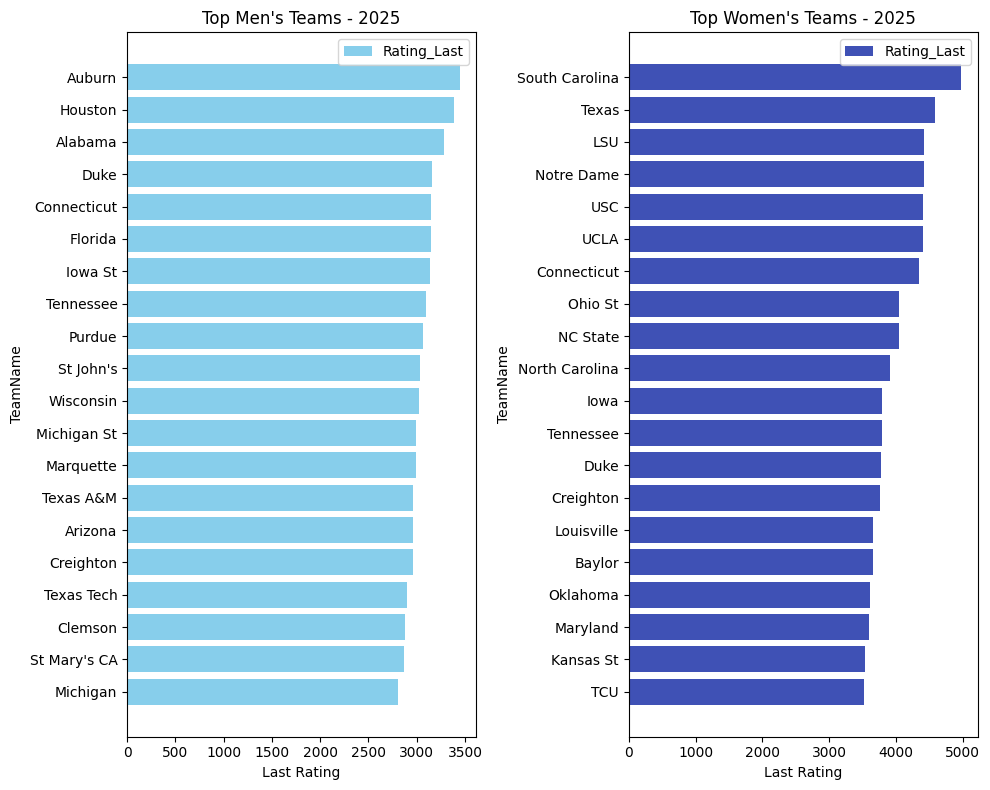

In [6]:
# Men's Teams
tmp_df_men = pd.merge(elo_df_men, teams_m, on='TeamID', how='left')
tmp_df_men = tmp_df_men[tmp_df_men['Season'] == 2025]
top_men_teams = tmp_df_men.sort_values('Rating_Last', ascending=False)[:20][['TeamName', 'Rating_Last', 'Rating_Trend']]
top_men_teams = top_men_teams.reindex(index=top_men_teams.index[::-1])

# Women's Teams
tmp_df_women = pd.merge(elo_df_women, teams_w, on='TeamID', how='left')
tmp_df_women = tmp_df_women[tmp_df_women['Season'] == 2025]
top_women_teams = tmp_df_women.sort_values('Rating_Last', ascending=False)[:20][['TeamName', 'Rating_Last', 'Rating_Trend']]
top_women_teams = top_women_teams.reindex(index=top_women_teams.index[::-1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))

# Men's Teams
ax1.barh(top_men_teams['TeamName'], top_men_teams['Rating_Last'], color='skyblue', label='Rating_Last')
ax1.set_title("Top Men's Teams - 2025")
ax1.set_xlabel('Last Rating')
ax1.set_ylabel('TeamName')
ax1.legend()

# Women's Teams
ax2.barh(top_women_teams['TeamName'], top_women_teams['Rating_Last'], color='#3F51B5', label='Rating_Last')
ax2.set_title("Top Women's Teams - 2025")
ax2.set_xlabel('Last Rating')
ax2.set_ylabel('TeamName')
ax2.legend()

plt.tight_layout()
plt.show()

In [10]:
# 生成比赛预测结果
def generate_match_predictions(elo_df, teams, season=2025):
    predictions = []
    
    for i in range(len(teams)):
        for j in range(i + 1, len(teams)):
            team1_id = teams[i]
            team2_id = teams[j]
            
            # 获取两支队伍的 Elo 评分
            rating_team1 = elo_df[(elo_df['TeamID'] == team1_id) & (elo_df['Season'] == season)]['Rating_Last'].values[0]
            rating_team2 = elo_df[(elo_df['TeamID'] == team2_id) & (elo_df['Season'] == season)]['Rating_Last'].values[0]
            
            # 计算胜率
            expected_score_team1 = 1 / (1 + 10 ** ((rating_team2 - rating_team1) / 400))
            
            # 生成 ID
            match_id = f"{season}_{team1_id}_{team2_id}"
            
            # 添加到预测列表
            predictions.append([match_id, expected_score_team1])
    
    # 创建 DataFrame
    predictions_df = pd.DataFrame(predictions, columns=['ID', 'Pred'])
    return predictions_df

In [11]:
# 生成男子组比赛预测
men_teams_2025 = teams_m[teams_m['TeamID'].isin(elo_df_men[elo_df_men['Season'] == 2025]['TeamID'])]['TeamID'].values
men_predictions = generate_match_predictions(elo_df_men, men_teams_2025)

# 生成女子组比赛预测
women_teams_2025 = teams_w[teams_w['TeamID'].isin(elo_df_women[elo_df_women['Season'] == 2025]['TeamID'])]['TeamID'].values
women_predictions = generate_match_predictions(elo_df_women, women_teams_2025)

# 合并所有预测
all_predictions = pd.concat([men_predictions, women_predictions])

# 保存到 CSV
all_predictions.to_csv('match_predictions.csv', index=False)

# 输出前几行以检查
print(all_predictions.head())

               ID      Pred
0  2025_1101_1102  0.959869
1  2025_1101_1103  0.007916
2  2025_1101_1104  0.000005
3  2025_1101_1105  0.994527
4  2025_1101_1106  0.971754
